## Importing the relevant packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data 

In [2]:
raw_data = yf.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI", 
                       start="1994-01-07", 
                       end="2018-01-29", 
                       interval="1d", 
                       group_by='ticker', 
                       auto_adjust=True, 
                       threads=True)

[*********************100%%**********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.ffill()

## Creating Returns

In [6]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [7]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [8]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [9]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [10]:
df.tail()

Ticker,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
Price,,,,,,,,,,,,
Date,,,,,,,,,,,,
2013-04-01,1562.170044,7795.310059,6411.700195,12135.019531,-0.447358,0.000000,0.000000,-2.120443,186.507731,-0.000000,0.000000,-935.368371
2013-04-02,1570.250000,7943.870117,6490.700195,12003.429688,0.517226,1.232122,1.905762,-1.084381,-215.636502,-158.180337,1367.802234,-478.341386
2013-04-03,1553.689941,7874.750000,6420.299805,12362.200195,-1.054613,-1.084635,-0.870106,2.988900,439.677916,139.245809,-624.492133,1318.461488
2013-04-04,1559.979980,7817.390137,6344.100098,12634.540039,0.404845,-1.186856,-0.728402,2.203005,-168.783728,152.368996,-522.788437,971.787879
2013-04-05,1553.280029,7658.750000,6249.799805,12833.639648,-0.429490,-1.486425,-2.029324,1.575836,179.058193,190.827793,-1456.484709,695.131611


In [11]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-15"
end_date = "2015-01-01"
df_pred = results_ar.predict(start = start_date, end = end_date)

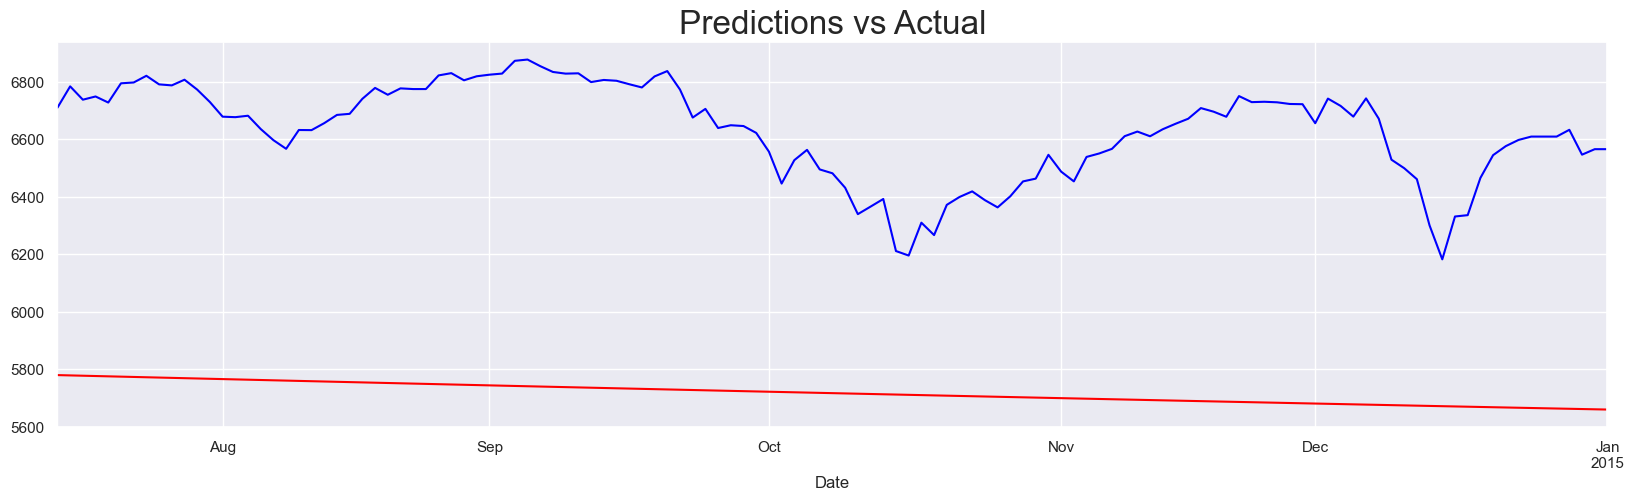

In [12]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [13]:
end_date = "2018-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

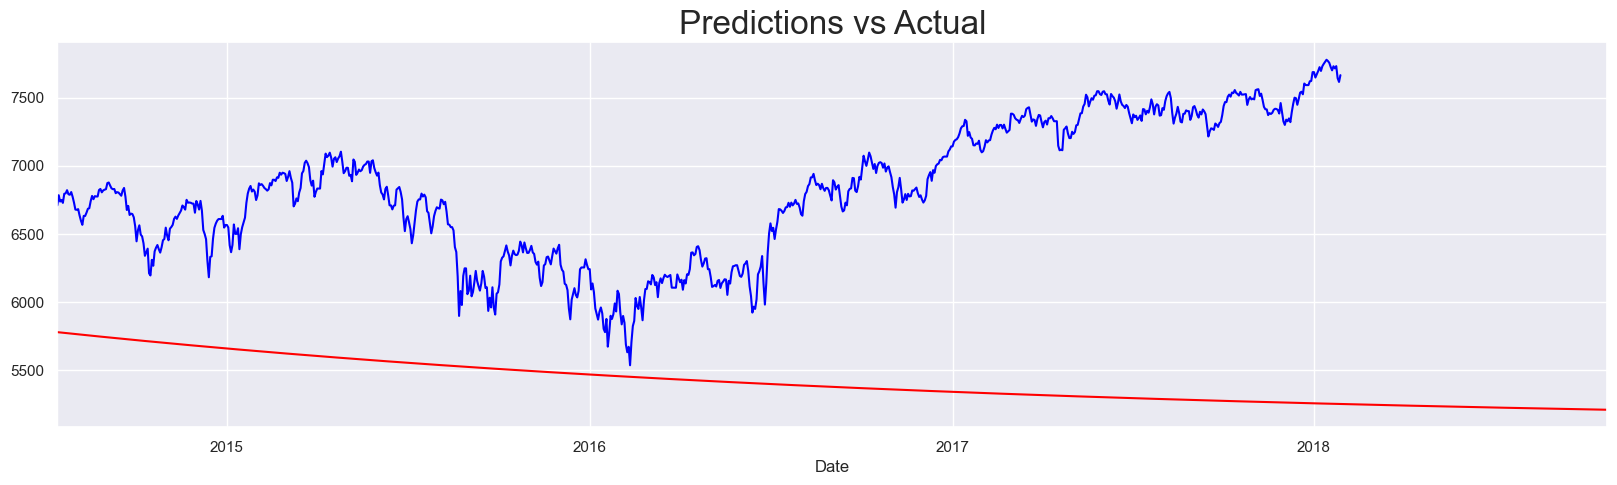

In [14]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

## Using Returns Instead

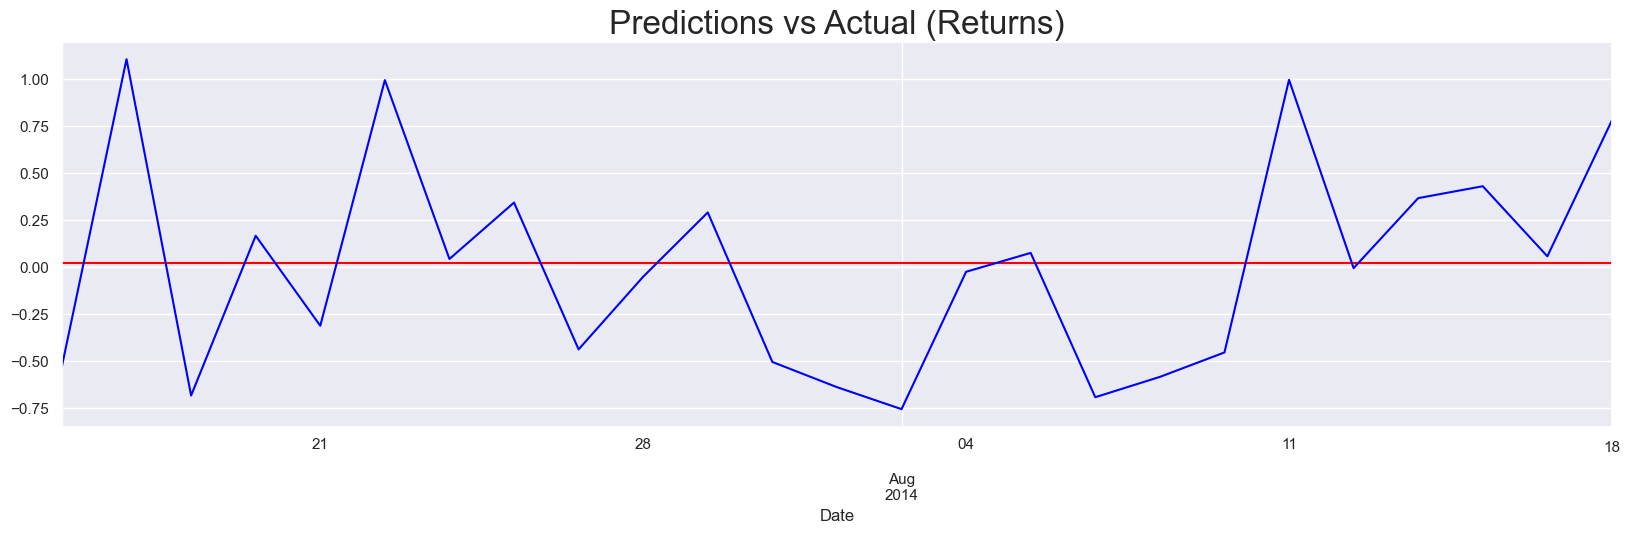

In [15]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [16]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5019
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7891.459
Date:                Mon, 05 Aug 2024   AIC                          15796.918
Time:                        00:25:35   BIC                          15842.565
Sample:                    01-11-1994   HQIC                         15812.913
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.277      0.202      -0.010       0.048
ar.L1         -0.0218      0.009     -2.398      0.016      -0.040      -0.004
ar.L2         -0.0545      0.008     -6.835      0.000      -0.070      -0.039
ar.L3         -0.0833      0.008    -10.422      0.000      -0.099      -0.068
ar.L4          0.0449      0.008      5.424      0.000       0.029       0.061
ar.L5         -0.0594      0.008     -7.436      0.000      -0.075      -0.044
sigma2         1.3590      0.015     92.498      0.000       1.330       1.388
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              6389.23
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## MA

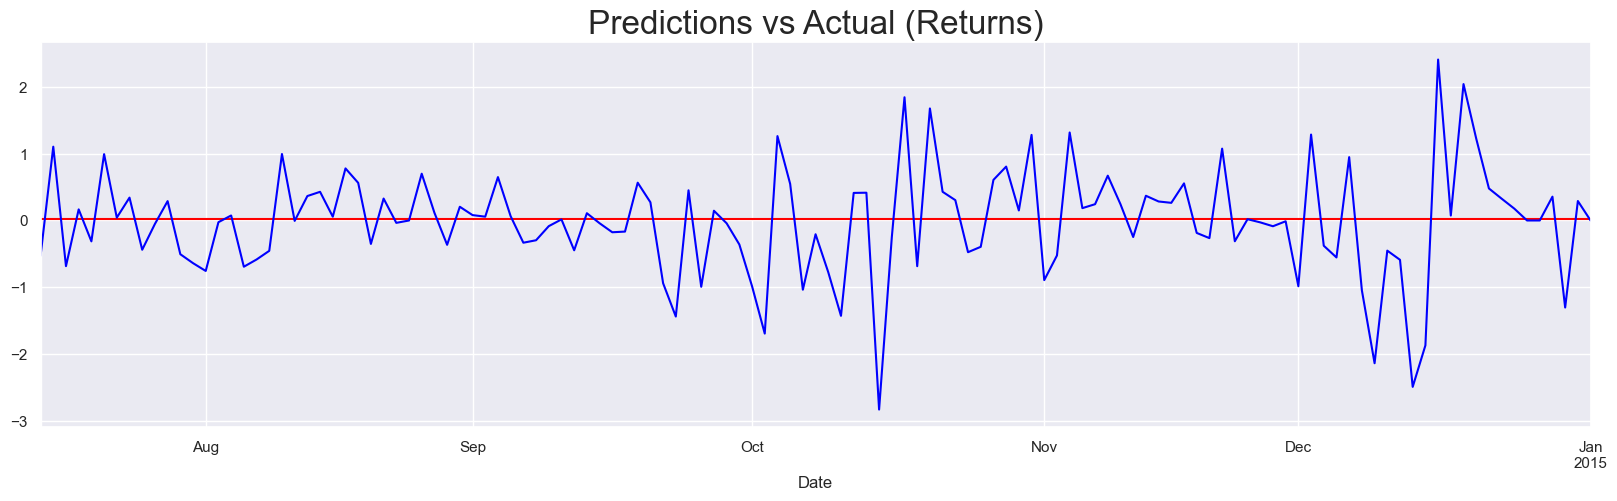

In [17]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [18]:
df_pred_ma.head()

2014-07-15    0.018805
2014-07-16    0.018805
2014-07-17    0.018805
2014-07-18    0.018805
2014-07-21    0.018805
Freq: B, Name: predicted_mean, dtype: float64

## ARMA

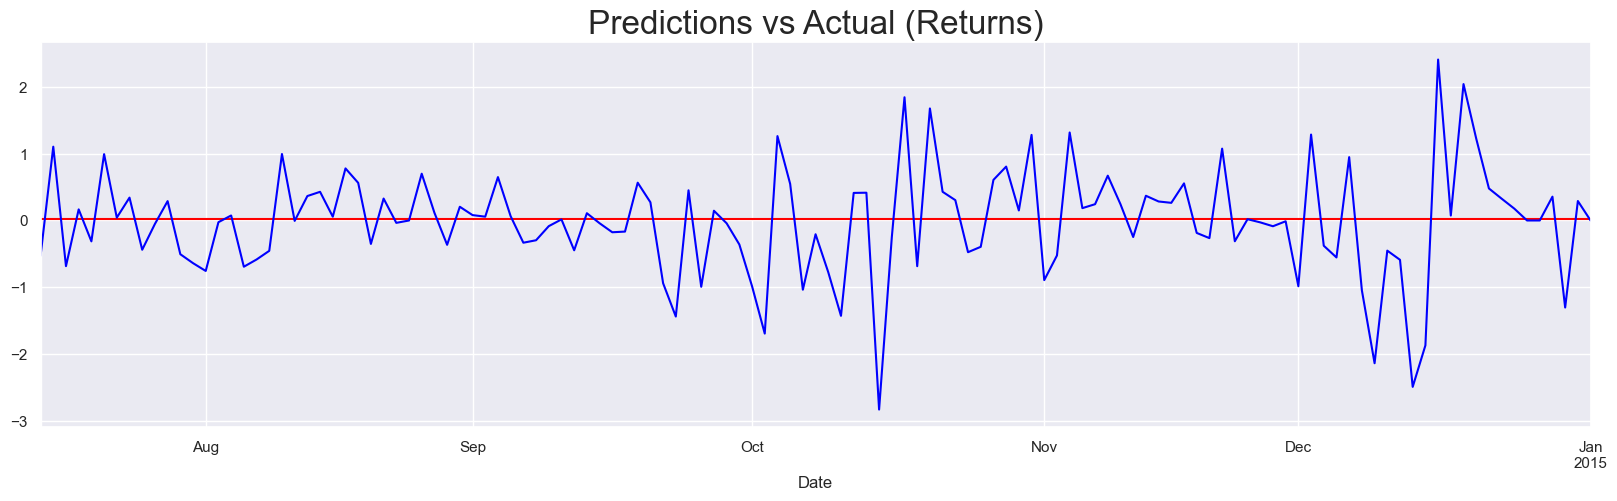

In [19]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [20]:
df_pred_arma.head()

2014-07-15    0.018935
2014-07-16    0.018935
2014-07-17    0.018935
2014-07-18    0.018935
2014-07-21    0.018935
Freq: B, Name: predicted_mean, dtype: float64

In [21]:
df_pred_arma.tail()

2014-12-26    0.018935
2014-12-29    0.018935
2014-12-30    0.018935
2014-12-31    0.018935
2015-01-01    0.018935
Freq: B, Name: predicted_mean, dtype: float64

## ARMAX

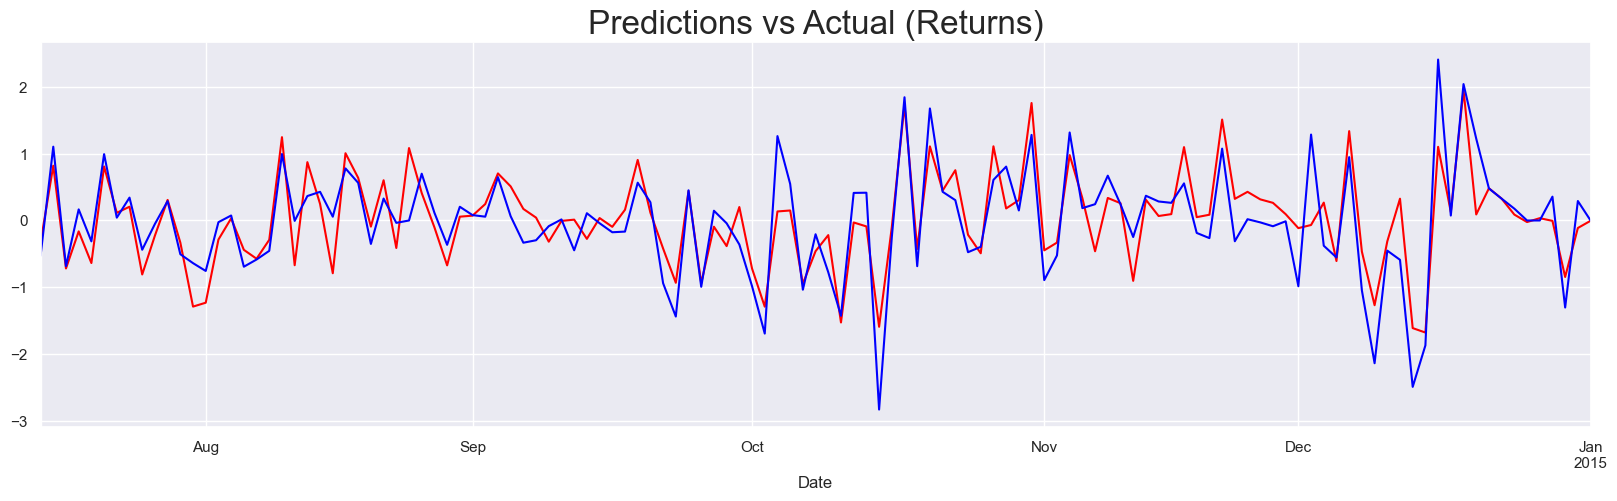

In [22]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

# Make predictions
exog = df_test[["ret_spx","ret_dax","ret_nikkei"]].reindex(index=df_test.index)
exog = exog.fillna(method='ffill')
exog = exog.iloc[:454]  # Select the first 454 rows
df_pred_armax = results_ret_armax.predict(start=start_date, end=end_date, exog=exog)

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## SARMA

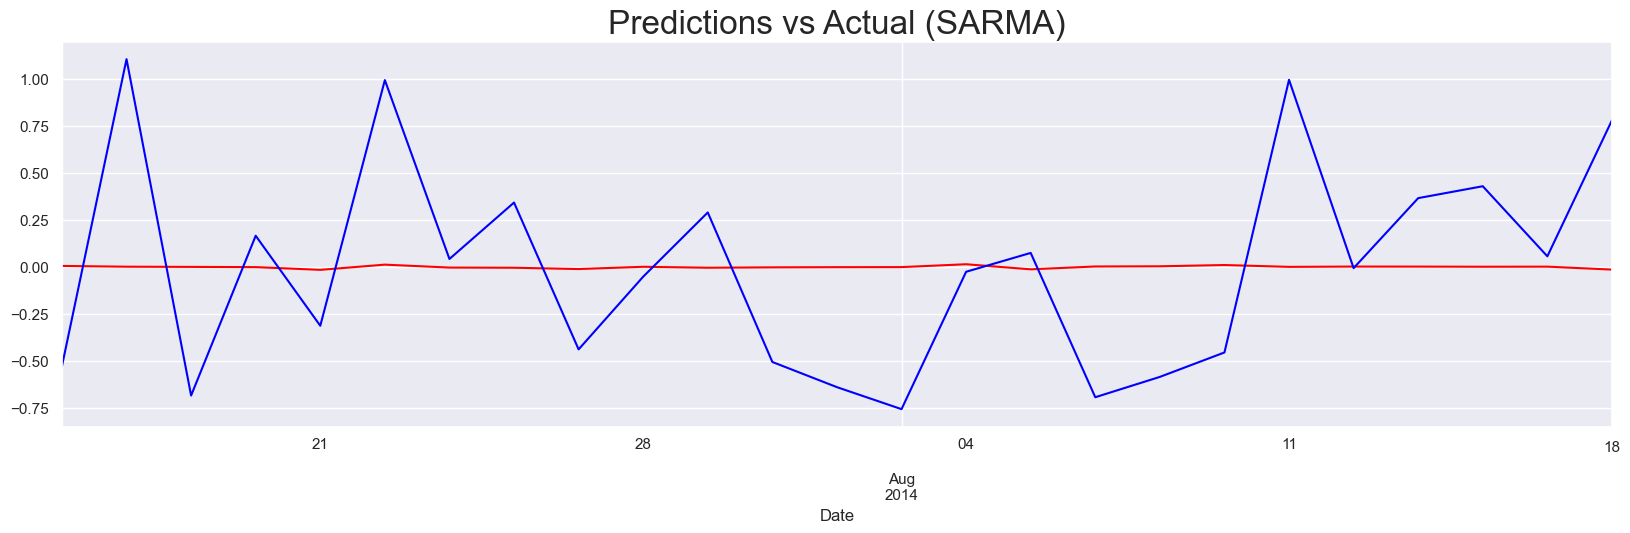

In [23]:
end_date = "2014-08-18"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,1), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

## SARIMAX

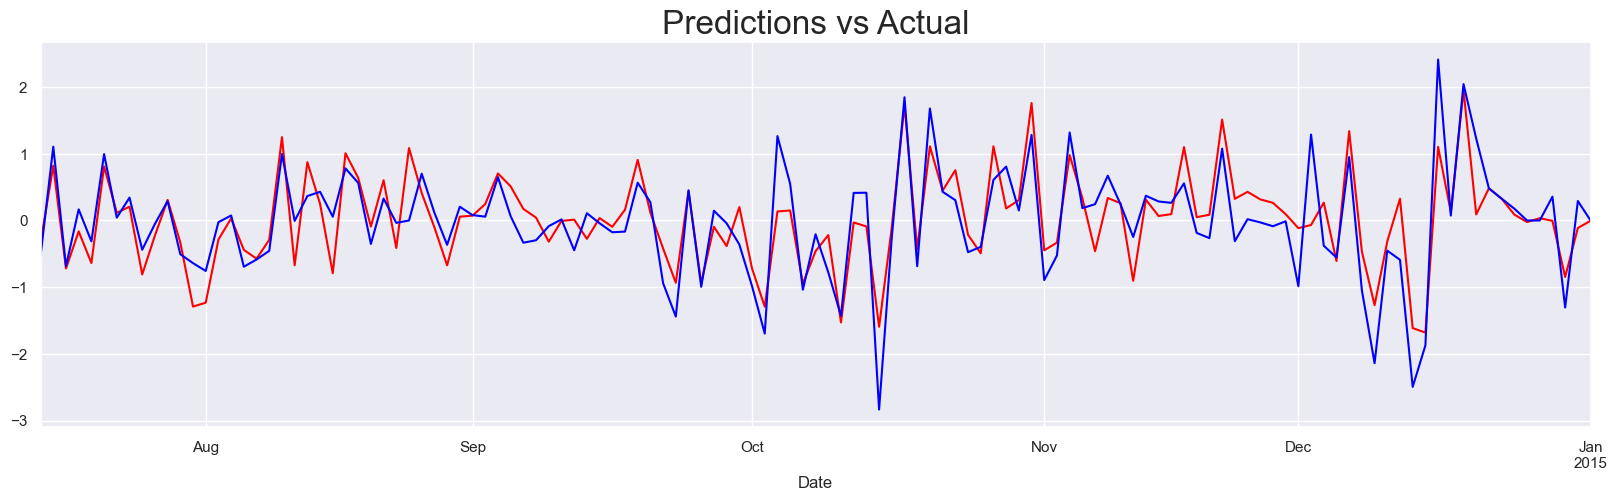

In [24]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

# Make predictions
exog = df_test[["ret_spx","ret_dax","ret_nikkei"]].reindex(index=df_test.index)
exog = exog.fillna(method='ffill')
exog = exog.iloc[:454]  # Select the first 454 rows
df_pred_sarimax = results_ret_armax.predict(start=start_date, end=end_date, exog=exog)

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

## Auto ARIMA

In [25]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, information_criterion = 'oob')

In [26]:
forecast, conf_int = model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                                        exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date],
                                        return_conf_int=True)

In [27]:
forecast_series = pd.Series(forecast.values, index=df_test[start_date:end_date].index)
df_auto_pred = pd.DataFrame(forecast_series, columns=['Forecast'])

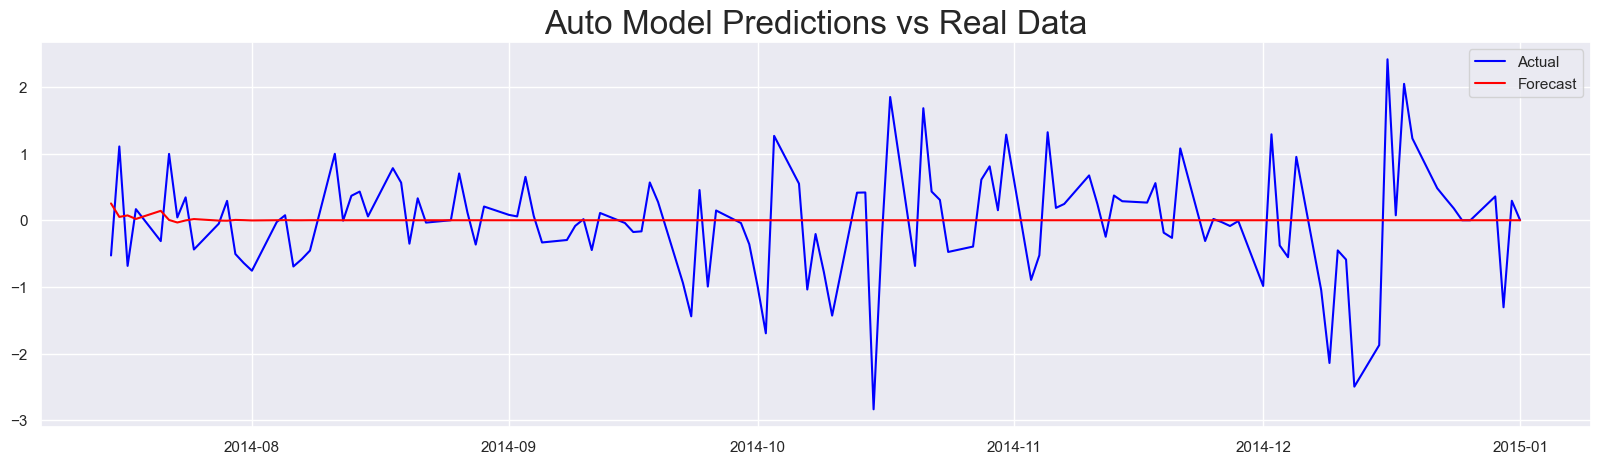

In [28]:
# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_test.ret_ftse[start_date:end_date], label='Actual', color='blue')
plt.plot(df_auto_pred, label='Forecast', color='red')
plt.title("Auto Model Predictions vs Real Data", size=24)
plt.legend()
plt.show()

In [29]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5019
Model:             SARIMAX(2, 0, 3)x(0, 0, [1], 5)   Log Likelihood               -7886.456
Date:                             Mon, 05 Aug 2024   AIC                          15786.913
Time:                                     00:30:03   BIC                          15832.560
Sample:                                 01-11-1994   HQIC                         15802.908
                                      - 04-05-2013                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3582      0.061     -5.830      0.000      -0.479      -0.238
ar.L2         -0.4958      0.060     -8.246      0.000      -0.614      -0.378
ma.L1          0.3343      0.059      5.629      0.000       0.218       0.451
ma.L2          0.4384      0.061      7.187      0.000       0.319       0.558
ma.L3         -0.1147      0.010    -11.988      0.000      -0.133      -0.096
ma.S.L5       -0.0751      0.010     -7.882      0.000      -0.094      -0.056
sigma2         1.3563      0.015     93.027      0.000       1.328       1.385
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6477.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Comparing All the Models (Returns)

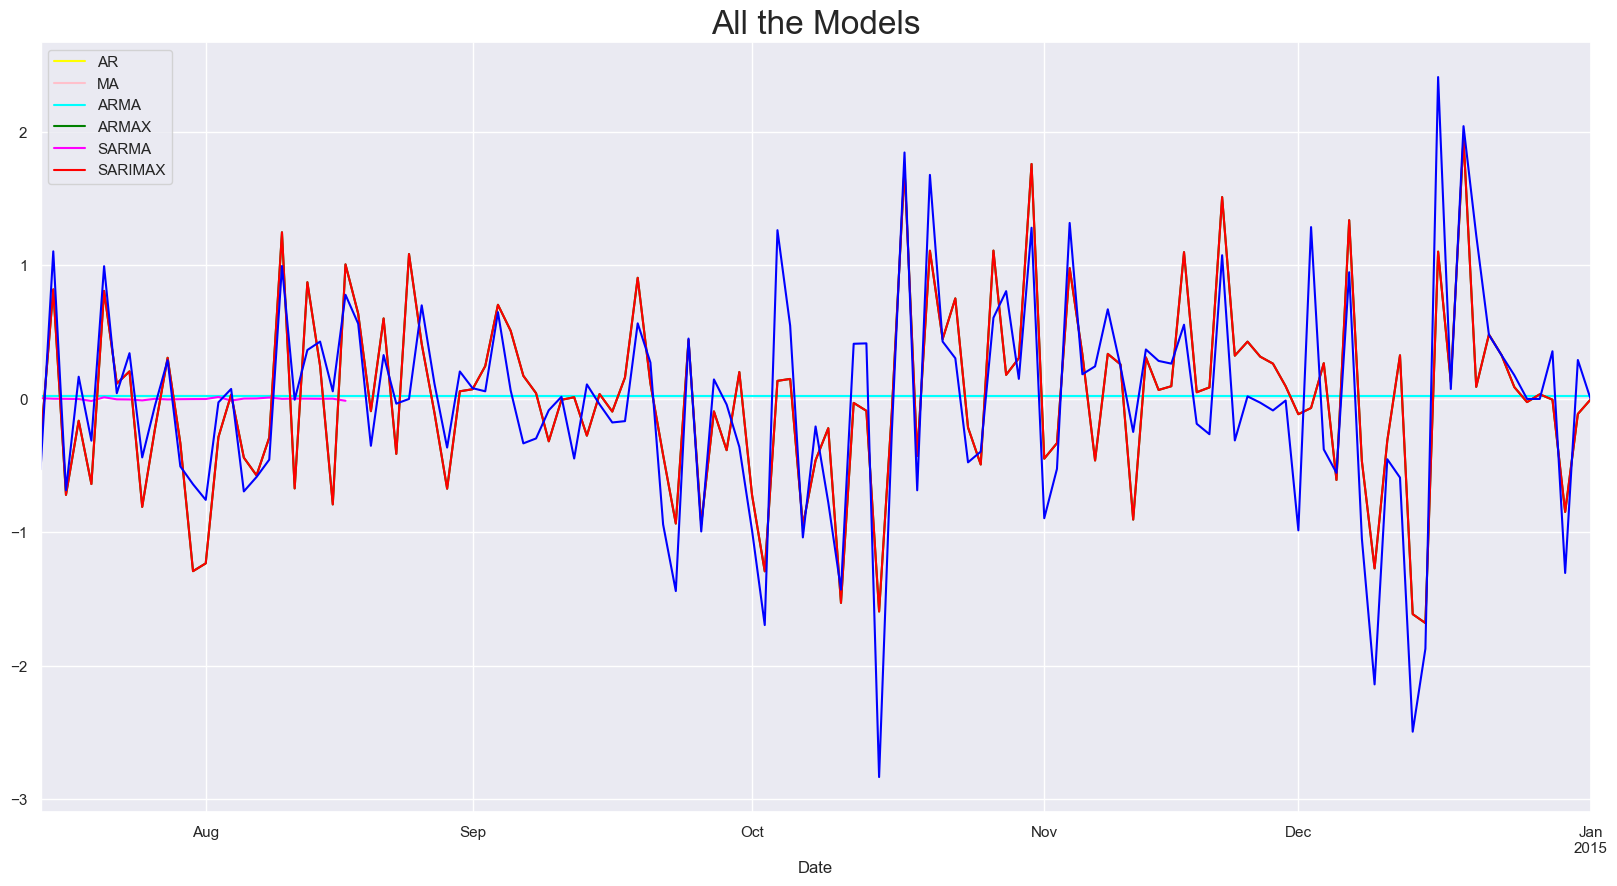

In [30]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

## Forecasting Volatility

In [31]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7309.738663281408
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7309.738653886703
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [32]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

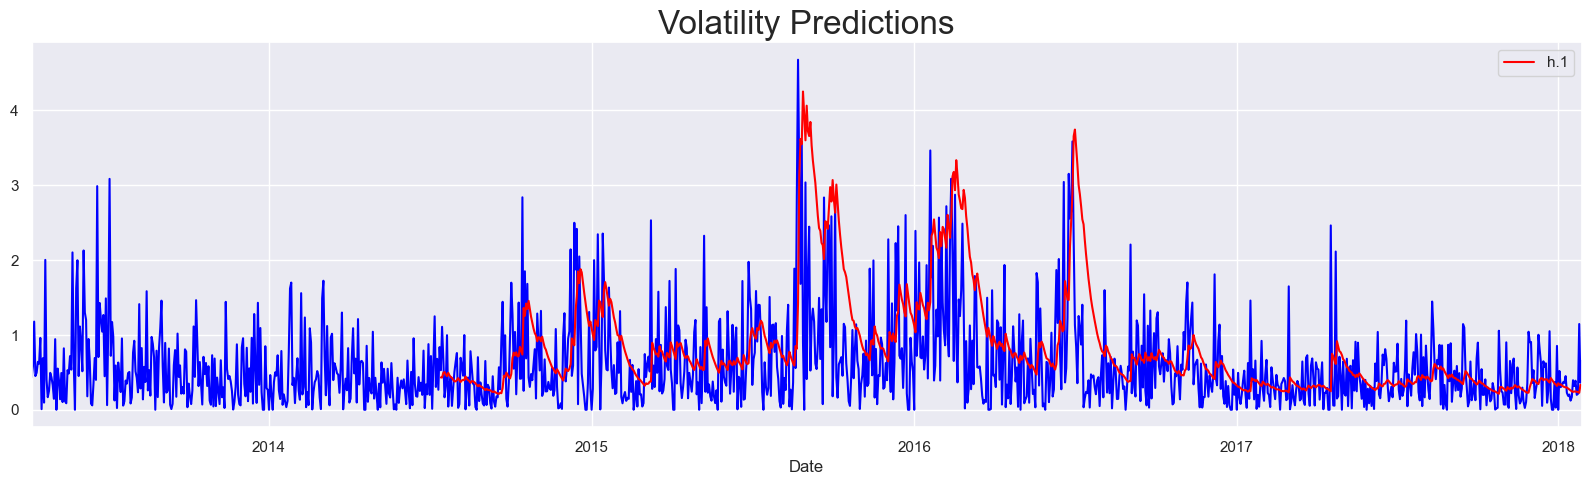

In [33]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [34]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,0.325666,0.339335,0.24341,0.259997,0.274505,0.284425,0.293391,0.29712,0.312694,0.330342,...,0.874867,0.891624,0.910146,0.927307,0.938552,0.904733,0.863216,0.872782,0.885312,0.892351


## Multvariate Regression Model

In [35]:
from statsmodels.tsa.api import VAR

In [36]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [37]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [38]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Aug, 2024
Time:                     00:30:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.449050
Nobs:                     5014.00    HQIC:                  0.378098
Log likelihood:          -29226.2    FPE:                    1.40470
AIC:                     0.339820    Det(Omega_mle):         1.38141
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.035802         0.017040            2.101           0.036
L1.ret_spx           -0.112462         0.018140           -6.200           0.000
L1.ret_dax            0.064253         0.019679           

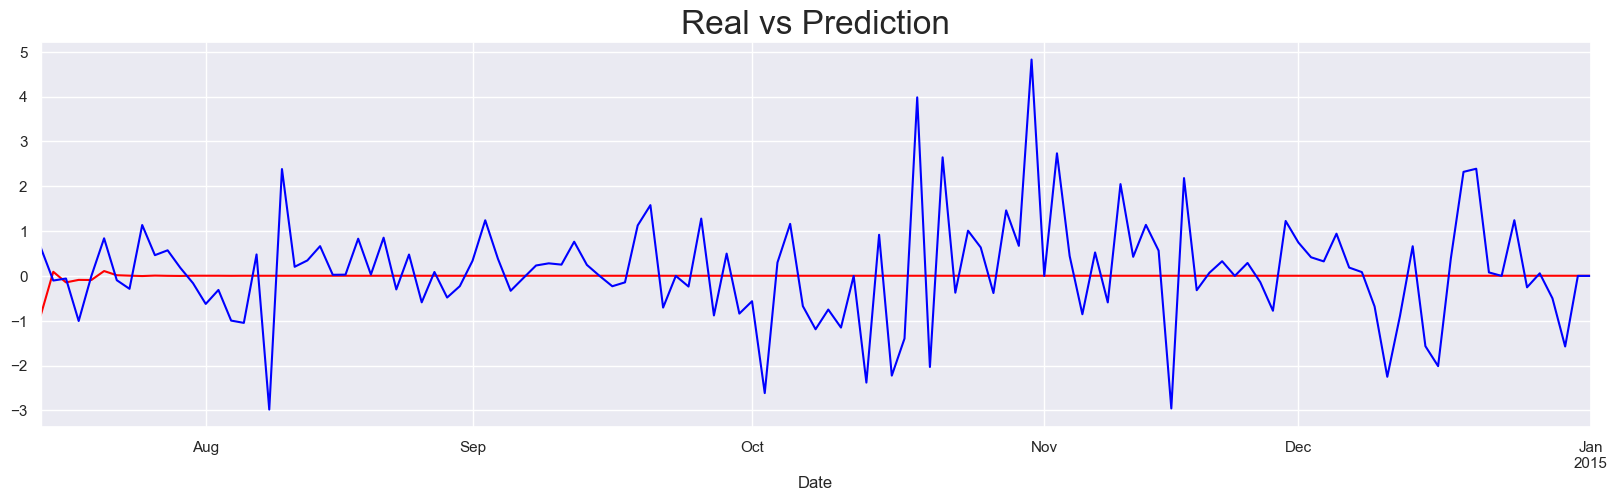

In [39]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

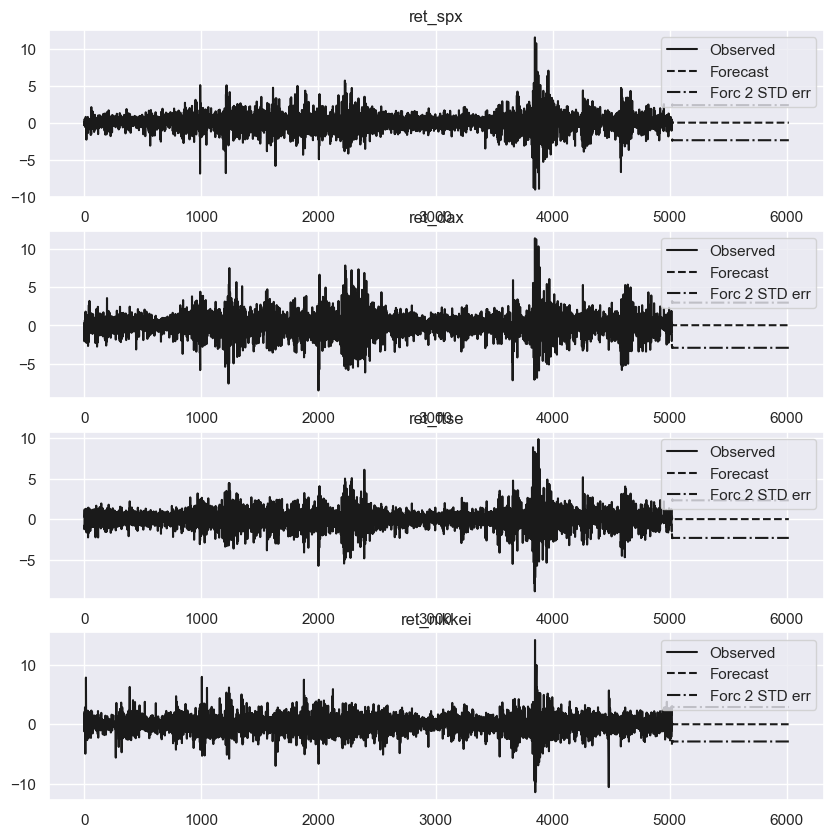

In [40]:
results_var_ret.plot_forecast(1000)
plt.show()